# 어떤 예측 모형이 차량 수요 예측에 가장 적합할까?

## 과제: 동적 회귀 모형을 이용해 차량 수요 예측을 하고 그 결과를 다른 모형들과 비교

In [1]:
# 모듈 import 및 버전 확인하기

import os
import requests
from io import BytesIO
from itertools import product
from datetime import datetime

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm
import pmdarima as pm  

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller # 정상성 검정
from statsmodels.tsa.arima_model import ARIMA

# 프로젝트용 모듈
from itertools import product
from tqdm import notebook
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor # 회귀트리(모델)

import warnings
warnings.filterwarnings( 'ignore' )

print("작업 완료")

작업 완료


## Step 1. 학습 데이터와 테스트 데이터 나누기

In [2]:
# 데이터 불러 오기
# 이전 노드에서 사전 가동률 데이터, 존 클릭 수 데이터, 날씨 데이터를 합하여 만든 데이터를 사용한다.
# df_raws 를 변형해서 진행해야 한다.

file_path_raws = './data/raws.csv'
df_raws_tmp = pd.read_csv(file_path_raws)
df_raws = df_raws_tmp.copy()

df_op_ts = df_raws.set_index('target_dates').sort_index()
df_op_ts.head(20)

,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,op_rate_1d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
target_dates,,,,,,,,,,,,,,,,,,,,,
2019-09-08,0.381038,0.134719,0.095673,0.081302,0.073248,0.067846,0.059269,0.050881,0.392379,0.130225,...,3850,1190,0,18.8,24.4,9,2019,36,6,True
2019-09-09,0.294693,0.094521,0.058669,0.049279,0.040270,0.033519,0.029069,0.024346,0.316189,0.095190,...,2392,1777,0,90.4,24.7,9,2019,37,0,False
2019-09-10,0.327382,0.115586,0.065420,0.050327,0.043757,0.035807,0.030258,0.026159,0.359647,0.119441,...,2827,2526,0,127.7,24.9,9,2019,37,1,False
2019-09-11,0.382523,0.149016,0.094511,0.073380,0.062836,0.055696,0.048563,0.043774,0.409784,0.142832,...,5867,5083,0,98.4,24.1,9,2019,37,2,False
2019-09-12,0.559916,0.266497,0.201238,0.166553,0.143653,0.130768,0.119568,0.106934,0.568754,0.241148,...,9692,9838,0,38.8,21.3,9,2019,37,3,False
2019-09-13,0.718287,0.399703,0.328298,0.277056,0.239386,0.210855,0.193404,0.178260,0.726530,0.357470,...,6946,7328,0,0.4,22.0,9,2019,37,4,False
2019-09-14,0.589158,0.293503,0.246319,0.210351,0.180779,0.155396,0.138554,0.126423,0.602939,0.266121,...,3980,3004,0,1.7,22.2,9,2019,37,5,True
2019-09-15,0.411680,0.176116,0.136209,0.120233,0.105284,0.088849,0.074827,0.066085,0.422494,0.163079,...,2100,1427,0,4.0,23.4,9,2019,37,6,True
2019-09-16,0.281121,0.090146,0.059408,0.048795,0.042494,0.036145,0.029386,0.024723,0.312250,0.092969,...,2615,1872,0,1.2,22.9,9,2019,38,0,False


In [3]:
# 설명 변수(독립변수, I.V) 테이블 설정
# 설명 변수(독립변수)로 (1)존 클릭 수 (2)날씨 (3)요일을 사용, index = target_dates

_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]
_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False)
_x_data = pd.concat([_x_data, _x_weekday], axis=1)
_x_data.set_index("target_dates", drop=True, inplace=True)

_x_data = _x_data.sort_values('target_dates') # 추가 하였음, 날짜 정렬을 위해서

# 예측 대상 데이터 설정 
# 이놈도 마찬가지로 순서가 흐트러짐 
target = df_raws[['op_rate_0d_all_cars', 'target_dates' ]]
target = target.sort_values('target_dates') # 그래서 이 것을 추가

target.set_index("target_dates", drop=True, inplace=True)

# Train/Test 데이터셋 나누기
_x_data_train = _x_data[_x_data.index<'2021-04-01']
_x_data_test = _x_data[_x_data.index>='2021-04-01']
target_train = target[target.index<'2021-04-01']
target_test = target[target.index>='2021-04-01']

# 상수항 추가
x_data_train = sm.add_constant(_x_data_train, has_constant='add')
x_data_test = sm.add_constant(_x_data_test, has_constant='add')


In [4]:
x_train = _x_data_train
x_test = _x_data_test
y_train = target_train
y_test = target_test

In [5]:
x_train.head()

,click_d_1,click_d_2,click_d_3,click_d_4,click_d_5,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
target_dates,,,,,,,,,,,,,,,,,
2019-09-08,14536,8015,5475,5402,4175,3850,1190,0,18.8,24.4,0,0,0,0,0,0,1
2019-09-09,12409,8536,5944,4645,3099,2392,1777,0,90.4,24.7,1,0,0,0,0,0,0
2019-09-10,16907,6765,5872,3988,3544,2827,2526,0,127.7,24.9,0,1,0,0,0,0,0
2019-09-11,33534,18667,10726,8395,7222,5867,5083,0,98.4,24.1,0,0,1,0,0,0,0
2019-09-12,48475,31062,22307,13373,11206,9692,9838,0,38.8,21.3,0,0,0,1,0,0,0


In [6]:
y_train.head()

,op_rate_0d_all_cars
target_dates,
2019-09-08,0.381038
2019-09-09,0.294693
2019-09-10,0.327382
2019-09-11,0.382523
2019-09-12,0.559916


In [7]:
x_test.head()

,click_d_1,click_d_2,click_d_3,click_d_4,click_d_5,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
target_dates,,,,,,,,,,,,,,,,,
2021-04-01,17431,9529,5651,3617,3841,2930,2398,0,6.7,14.9,0,0,0,1,0,0,0
2021-04-02,19154,10843,8335,5999,3589,3332,2906,0,3.2,16.3,0,0,0,0,1,0,0
2021-04-03,25943,15758,12828,10240,8750,4849,3340,0,317.4,14.4,0,0,0,0,0,1,0
2021-04-04,16807,10889,7286,5095,4392,3422,1831,0,95.2,10.6,0,0,0,0,0,0,1
2021-04-05,13234,10249,7071,5287,4099,2786,2019,0,0.7,10.5,1,0,0,0,0,0,0


In [8]:
y_test.head()

,op_rate_0d_all_cars
target_dates,
2021-04-01,0.359158
2021-04-02,0.363552
2021-04-03,0.420870
2021-04-04,0.441205
2021-04-05,0.333956


## Step 2. Grid search

In [9]:
# 초기화
# 모수 설정 초기화
p = range(0, 2)
q = range(0, 2)
d = range(0, 2)
P = range(0, 2)
Q = range(0, 2)
D = range(0, 2)
S = range(7, 8)

# 변수 및 상태 초기화
best_AIC = float("inf")
best_model = sm.tsa.SARIMAX(endog=y_train, exog=x_train, order=(0, 1, 1), seasonal_order=(0, 0, 0, 7))
iter_cnt = 0
best_score = 0

# product를 사용한 모수 조합
# order 모수 조합
_list = [p, q, d]
pd = list(product(*_list))

# seasonal_order 모수 조합
_list2 = [P, Q, D, S]
pd2 = list(product(*_list2))


# for 문으로 최소 AIC 찾기 (Grid Search) 
for i in notebook.tqdm(pd, desc='order'):
    for j in notebook.tqdm(pd2, desc='seasonal_order'):
        try:
            # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
            best_model = sm.tsa.SARIMAX(endog=y_train, exog=x_train, order=i, seasonal_order=j)
            res = best_model.fit(disp=False)

            # AIC는 점수가 낮은게 좋은것이다. 점수가 가장 낮을 AIC를 기록해야 한다. 동시에 best_AIC의 파라메터를 저장한다.
            score_aic = res.aic # AIC 를 확인한다.

            if score_aic < best_AIC:
                best_AIC = score_aic
                best_parameters_order = i
                best_parameters_seasonal = j
                print('SARIMAX',best_parameters_order,'x',best_parameters_seasonal,', AIC=', best_AIC, 'best so far')
            else:
                print('SARIMAX',best_parameters_order,'x',best_parameters_seasonal,', AIC=', score_aic)
        except:
            print("Unexpected error: ", sys.exc_info()[0])
            continue
            
#grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)  # 이 것은 추후에 고려할 것

order:   0%|          | 0/8 [00:00<?, ?it/s]

seasonal_order:   0%|          | 0/8 [00:00<?, ?it/s]

SARIMAX (0, 0, 0) x (0, 0, 0, 7) , AIC= 867.348384670026 best so far
SARIMAX (0, 0, 0) x (0, 0, 1, 7) , AIC= -2232.039497892646 best so far
SARIMAX (0, 0, 0) x (0, 0, 1, 7) , AIC= 1000.9463850813163
SARIMAX (0, 0, 0) x (0, 0, 1, 7) , AIC= -2156.502271114409
SARIMAX (0, 0, 0) x (1, 0, 0, 7) , AIC= -2244.151968996891 best so far
SARIMAX (0, 0, 0) x (1, 0, 1, 7) , AIC= -2245.725946960657 best so far
SARIMAX (0, 0, 0) x (1, 0, 1, 7) , AIC= -2097.281652631352
SARIMAX (0, 0, 0) x (1, 0, 1, 7) , AIC= -2141.838830446516


seasonal_order:   0%|          | 0/8 [00:00<?, ?it/s]

SARIMAX (0, 0, 1) x (0, 0, 0, 7) , AIC= -2326.255845821871 best so far
SARIMAX (0, 0, 1) x (0, 0, 1, 7) , AIC= -2348.608475571003 best so far
SARIMAX (0, 0, 1) x (0, 0, 1, 7) , AIC= -2097.1096732345623
SARIMAX (0, 0, 1) x (0, 0, 1, 7) , AIC= -2237.584974794054
SARIMAX (0, 0, 1) x (1, 0, 0, 7) , AIC= -2352.472942645917 best so far
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2354.9173561396174 best so far
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2183.9283513154023
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2224.972544302542


seasonal_order:   0%|          | 0/8 [00:00<?, ?it/s]

SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= 828.3270365513139
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2230.4609943477835
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= 1079.4878717660326
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2123.6548997579944
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2231.0012112507748
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2229.2245994491627
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2026.7396797160968
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2100.783924702622


seasonal_order:   0%|          | 0/8 [00:00<?, ?it/s]

SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2223.065123007402
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2235.2376902742653
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -1928.3753765446645
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2098.050273167264
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2236.3139222857794
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2234.259160233128
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2024.508877572076
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2080.989540889248


seasonal_order:   0%|          | 0/8 [00:00<?, ?it/s]

SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2328.2496306026455
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2349.300891335197
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2081.6249715091926
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2222.231711754588
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2348.853823586298
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2351.501477244071
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2167.9788999076704
SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2209.7008264689744


seasonal_order:   0%|          | 0/8 [00:00<?, ?it/s]

SARIMAX (0, 0, 1) x (1, 0, 1, 7) , AIC= -2338.4179737496042
SARIMAX (1, 0, 1) x (0, 0, 1, 7) , AIC= -2361.020447602354 best so far
SARIMAX (1, 0, 1) x (0, 0, 1, 7) , AIC= -2093.206329000931
SARIMAX (1, 0, 1) x (0, 0, 1, 7) , AIC= -2234.1945651023843
SARIMAX (1, 0, 1) x (1, 0, 0, 7) , AIC= -2364.039469933754 best so far
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2366.2483215650873 best so far
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2180.5632596705045
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2221.5688376700386


seasonal_order:   0%|          | 0/8 [00:00<?, ?it/s]

SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2219.56380521853
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2231.498040106594
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -1924.5938214522234
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2091.9025543848948
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2232.493481239304
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2230.4398898934824
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2018.8485562348847
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2074.796158861395


seasonal_order:   0%|          | 0/8 [00:00<?, ?it/s]

SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2263.6798573253186
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2274.1904440029084
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -1969.9126481379772
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2134.9613869011546
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2275.3266259246293
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2273.1437621688983
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2063.5276813605446
SARIMAX (1, 0, 1) x (1, 0, 1, 7) , AIC= -2118.2677725957656


## Step3. 모형 구조 확인

In [10]:
best_model = sm.tsa.SARIMAX(endog=y_train, exog=x_train, 
                            order=(1, 1, 2), 
                            seasonal_order=(1, 0, 0, 7),
                            enforce_stationarity=True,
                            enforce_invertibility=True)
res = best_model.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                op_rate_0d_all_cars   No. Observations:                  571
Model:             SARIMAX(1, 1, 2)x(1, 0, [], 7)   Log Likelihood                1213.464
Date:                            Fri, 25 Mar 2022   AIC                          -2382.928
Time:                                    11:27:36   BIC                          -2287.324
Sample:                                09-08-2019   HQIC                         -2345.626
                                     - 03-31-2021                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
click_d_1          6.153e-06   5.02e-07     12.250      0.000    5.17e-06    7.14e-06
click_d_2     

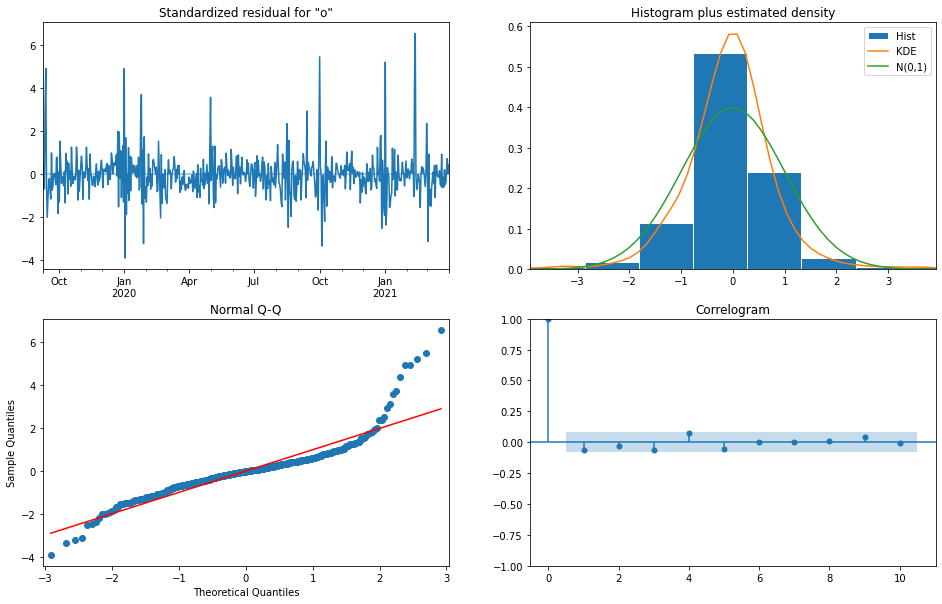

In [11]:
res.plot_diagnostics(figsize=(16, 10))
plt.show()

## Step 4. 차량 수요 예측
예측값과 예측값의 신뢰구간을 얻을 수 있는 get_forecast(steps=n)을 사용해 보세요.  
학습 데이터 다음부터 지정한 steps만큼 예측할 수 있어요.  
RMSE와 시각화를 통해 모형의 예측 정확도를 확인해 보세요.  
RMSE을 구할 때는 예측값에 .predicted_mean을 사용해보세요.  
시각화할 때는 이전 스텝에서와 같이 마지막 50개의 데이터만 사용하세요.

In [12]:
## 생성된 모델을 사용하여 차량의 수요를 예측
pred = res.get_forecast(steps=52, exog=x_test)
pred_ci = pred.conf_int() # 상한m 하한 시각화를 위한 
pred_ci.head(10)

,lower op_rate_0d_all_cars,upper op_rate_0d_all_cars
2021-04-01,0.296472,0.410152
2021-04-02,0.275002,0.418843
2021-04-03,0.327250,0.476140
2021-04-04,0.322559,0.472700
2021-04-05,0.226322,0.376943
2021-04-06,0.249573,0.400473
2021-04-07,0.255949,0.407065
2021-04-08,0.267447,0.420686
2021-04-09,0.282407,0.437115
2021-04-10,0.421697,0.576988


In [13]:
y_forecasted = pred.predicted_mean
y_forecasted.head(10)

2021-04-01    0.353312
2021-04-02    0.346922
2021-04-03    0.401695
2021-04-04    0.397629
2021-04-05    0.301632
2021-04-06    0.325023
2021-04-07    0.331507
2021-04-08    0.344067
2021-04-09    0.359761
2021-04-10    0.499342
Freq: D, Name: predicted_mean, dtype: float64

### RMSE

In [14]:
sarima_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_forecasted))
print(f'RMSE: {sarima_rmse}\n')

RMSE: 0.022441779811995258



### 시각화

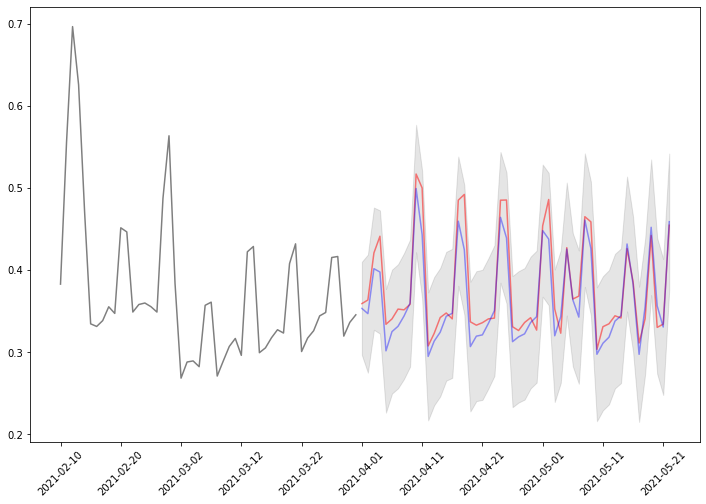

In [15]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

#plt.legend()
plt.plot(y_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(y_test.index.values, y_forecasted, alpha=0.4, color='blue', label='predicted operation rate')

ax.fill_between(target_test.index.values,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)

plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=10.0) 
ax.xaxis.set_major_locator(loc)

plt.show()

## Step 5. 다른 모형 사용하기

### LGBM

In [16]:
d_train = lgb.Dataset(x_train[:400], y_train[:400])
d_val = lgb.Dataset(x_train[400:], y_train[400:])
#d_val = lgb.Dataset(x_test, y_test)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 17
[LightGBM] [Info] Start training from score 0.382591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [17]:
preds2 = model.predict(x_test)
preds2

array([0.3457715 , 0.34825295, 0.41611008, 0.41163181, 0.31998599,
       0.32996058, 0.34048233, 0.34692519, 0.38507255, 0.51276938,
       0.44594599, 0.31885325, 0.32915372, 0.34835579, 0.33814661,
       0.36286012, 0.51276938, 0.4454987 , 0.31831108, 0.32895364,
       0.34581395, 0.35390969, 0.37003009, 0.5146711 , 0.44594599,
       0.33230006, 0.32766774, 0.34293599, 0.34429865, 0.36286012,
       0.4422586 , 0.44733682, 0.33230006, 0.34934471, 0.43341351,
       0.38470668, 0.35665704, 0.4827679 , 0.44399482, 0.32007251,
       0.32777383, 0.3510804 , 0.35802601, 0.36768691, 0.44035688,
       0.39919075, 0.32277984, 0.35607659, 0.51396745, 0.35810947,
       0.33553119, 0.47638873])

In [18]:
lgbm_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, preds2))
print(f'RMSE: {lgbm_rmse}\n')

RMSE: 0.022713714099060426



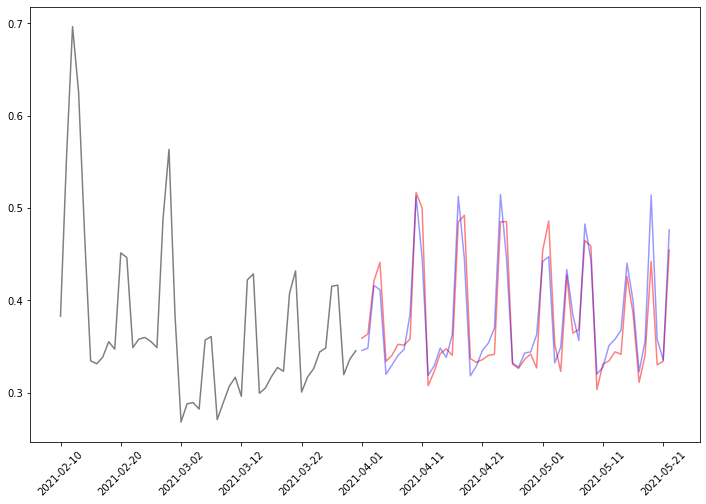

In [19]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

#plt.legend()
plt.plot(y_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, preds2, alpha=0.4, color='blue', label='predicted operation rate')

plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=10.0) 
ax.xaxis.set_major_locator(loc)

plt.show()

###  XBG

In [20]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [21]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)
reg2 = reg.predict(x_test)

xbg_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, reg2))
print(f'RMSE: {xbg_rmse}\n')

RMSE: 0.02097678343494172



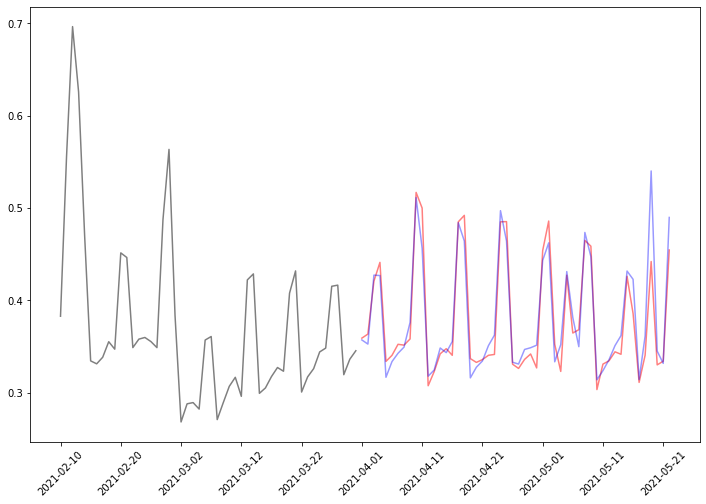

In [22]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

#plt.legend()
plt.plot(y_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, reg2, alpha=0.4, color='blue', label='predicted operation rate')

plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=10.0) 
ax.xaxis.set_major_locator(loc)

plt.show()

### RandomForestRegressor

In [23]:
model3 = RandomForestRegressor()
model3.fit(X = x_train, y = y_train)

RandomForestRegressor()

In [24]:
y_pred = model3.predict(x_test)

ran_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
print(f'RMSE: {ran_rmse}\n')

RMSE: 0.019729504687748943



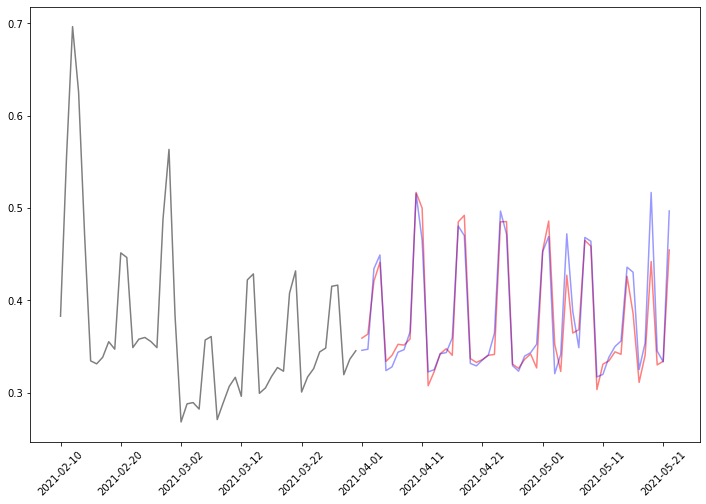

In [25]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

#plt.legend()
plt.plot(y_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, y_pred, alpha=0.4, color='blue', label='predicted operation rate')

plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=10.0) 
ax.xaxis.set_major_locator(loc)

plt.show()

## Step 6. 결과분석 및 비교

범위 조건을 다음과 같이 설정하여 최적의 AIC를 산출하는 모수를 결정하였다.  
본 노트북 파일은 LMS에서 진행하였고  
아래의 결과는 시간이 많이 걸리는 관계로 딥러닝용으로 세팅된 로컬 컴퓨터에서 진행하였으므로 본 노트북 파일에는  
아래 모수의 범위를 적용한 산출 과정이 기술되어 있지 않다. 본 노트북 파일에는 (0, 2) 를 적용한 산출과정의 기록이 있다.

- p = range(0, 3)
- q = range(0, 3)
- d = range(0, 3)
- P = range(0, 3)
- Q = range(0, 3)
- D = range(0, 3)

위 모수를 사용한 경우에 산출된 최적의 파라메터는 다음과 같다. 

- p = 1
- q = 1
- d = 1
- P = 1
- Q = 0
- D = 0

- S = 7

위 파라메터를 SARIMAX 모델에 사용하였다.


### 각 모델의 RMSE 값의 비교

|      | 동적 회기모형 | LGBM       | XBG        | RandomForestRegressor |
| ---- | ------------- | ---------- | ---------- | --------------------- |
| RMSE | 0.02244178    | 0.02271371 | 0.02098418 | 0.019876763           |

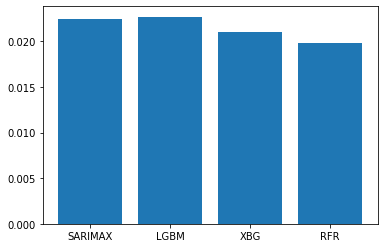

In [26]:
x = np.arange(4)
years = ['SARIMAX', 'LGBM', 'XBG', 'RFR']
result = [0.02244178, 0.02271371, 0.02098418, 0.019876763]

plt.bar(x, result)
plt.xticks(x, years)

plt.show()


단순하게 RMSE 값의 비교만으로는 RandomForestRegressor가 가장 작다.  
RandomForestRegressor < XBG < SARIMAX < LGBM 순서이다.

## 회고

역대급으로 재미 있게 했었던 노드였다. 
그리드서치의 경우 내가 직접 생각해서 알고리즘을 구현해 보려고 최대한 노력했다.
나중에 검색을 해본결과 내가 구현한 알고리즘과 검색한 알고리즘 간에 다른점이 발견되었고 많은 것을 배울 수 있었던 좋은 과정이었던 것 같다.  
그리드서치를 혼자서 구현해 보려고 노력한 점 이외에는 크게 어려운 점은 없었던 노드였다.